Datasets

In [13]:
import tensorflow as tf
import os

# Assuming you have two folders: real_images_folder and segmented_images_folder
real_images_folder = '/content/drive/MyDrive/Artist_AI/Datasets/ProductImageWhiteBg'
segmented_images_folder = '/content/drive/MyDrive/Artist_AI/Datasets/CannyProductImage'

real_image_paths = sorted([os.path.join(real_images_folder, filename) for filename in os.listdir(real_images_folder)])
segmented_image_paths = sorted([os.path.join(segmented_images_folder, filename) for filename in os.listdir(segmented_images_folder)])

# Pair up the paths
paired_paths = list(zip(real_image_paths, segmented_image_paths))

# Custom data loader
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, tf.float32)  # Ensure that the image is in float32 format
    image = (image / 127.5) - 1
    return image

def load_data(real_image_path, segmented_image_path):
    real_image = load_image(real_image_path)
    segmented_image = load_image(segmented_image_path)
    return real_image, segmented_image

def create_dataset(paired_paths):
    dataset = tf.data.Dataset.from_tensor_slices(paired_paths)
    dataset = dataset.map(lambda x: load_data(x[0], x[1]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(8)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [14]:
paired_paths[0]

('/content/drive/MyDrive/Artist_AI/Datasets/ProductImageWhiteBg/10037.jpg',
 '/content/drive/MyDrive/Artist_AI/Datasets/CannyProductImage/10037.jpg')

Models

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, Model, models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [16]:
def unet_generator(input_shape=(256, 256, 3), num_filters=32):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = conv_block(inputs, num_filters)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, num_filters * 2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, num_filters * 4)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = conv_block(pool3, num_filters * 8)

    # Decoder
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same')(up5)
    up5 = layers.concatenate([up5, conv3], axis=-1)
    conv5 = conv_block(up5, num_filters * 4)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same')(up6)
    up6 = layers.concatenate([up6, conv2], axis=-1)
    conv6 = conv_block(up6, num_filters * 2)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(up7)
    up7 = layers.concatenate([up7, conv1], axis=-1)
    conv7 = conv_block(up7, num_filters)

    # Output layer
    outputs = layers.Conv2D(3, (1, 1), activation='tanh')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs, name='unet_generator')
    return model

def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

In [17]:
# Updated Discriminator function
def build_discriminator():
    input_shape = (256, 256, 3)

    input_img = layers.Input(shape=input_shape)
    target_img = layers.Input(shape=input_shape)

    x = layers.concatenate([input_img, target_img])  # Concatenate the input images

    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Output layer
    validity = layers.Conv2D(1, (4, 4), strides=(1, 1), padding='same')(x)

    return Model(inputs=[input_img, target_img], outputs=validity)

In [18]:
# Generator loss
def generator_loss(fake_output, target_output):
    target_output = tf.image.resize(target_output, (fake_output.shape[1], fake_output.shape[2]))
    return tf.keras.losses.MeanSquaredError()(target_output, fake_output)


# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)

# Conditional GAN model
generator = unet_generator()
discriminator = build_discriminator()

# Compile the models
generator.compile(optimizer=generator_optimizer, loss=generator_loss)
discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)

In [19]:
import matplotlib.pyplot as plt
# Function to visualize progress
def visualize_progress(generator, segmented_images, real_images, epoch):
    generated_images = generator(segmented_images, training=False)

    real_images = (real_images + 1) * 0.5
    segmented_images = (segmented_images + 1) * 0.5
    generated_images = (generated_images + 1) * 0.5

    plt.figure(figsize=(15, 5))

    for i in range(min(4, real_images.shape[0])):
        plt.subplot(3, 4, i + 1)
        plt.imshow(segmented_images[i])
        plt.title('Segmented Image')
        plt.axis('off')

        plt.subplot(3, 4, i + 5)
        plt.imshow(real_images[i])
        plt.title('Real Image')
        plt.axis('off')

        plt.subplot(3, 4, i + 9)
        plt.imshow(generated_images[i])
        plt.title('Generated Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [20]:
def save_model(generator, discriminator, generator_path, discriminator_path):
    # Save the generator model to the specified file path
    generator.save(generator_path)

    # Save the discriminator model to the specified file path
    discriminator.save(discriminator_path)

In [21]:
# Training function with U-Net architecture
def train_pix2pix(generator, discriminator, epochs, train_dataset, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss, save_interval=10, save_path='/content/drive/MyDrive/Artist_AI/saved_models'):
    # Create a directory for saving models if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    for epoch in range(epochs):
        for real_images, segmented_images in train_dataset:
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(segmented_images, training=True)
                real_output = discriminator([segmented_images, real_images], training=True)
                fake_output = discriminator([segmented_images, generated_images], training=True)
                gen_loss = generator_loss(fake_output, generated_images)
                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            # Calculate and print pixel distance
            pixel_distance = tf.reduce_mean(tf.abs(real_images - generated_images)).numpy()

        print(f"Epoch {epoch+1}/{epochs}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}, Pixel Distance: {pixel_distance}")

        # Print progress every few epochs
        if epoch % save_interval == 0:
            # Save and visualize generated images
            # Assuming visualize_progress function exists and is appropriate for your use case
            visualize_progress(generator, segmented_images, real_images, epoch)

    # Save models in SavedModel format at the end of training
    save_model(generator, discriminator, generator_path='/content/drive/MyDrive/Artist_AI/h5/generator.h5',
               discriminator_path='/content/drive/MyDrive/Artist_AI/h5/discriminator.h5')

Epoch 1/100, Generator Loss: 7.83860445022583, Discriminator Loss: 1.991330862045288, Pixel Distance: 0.3008728325366974


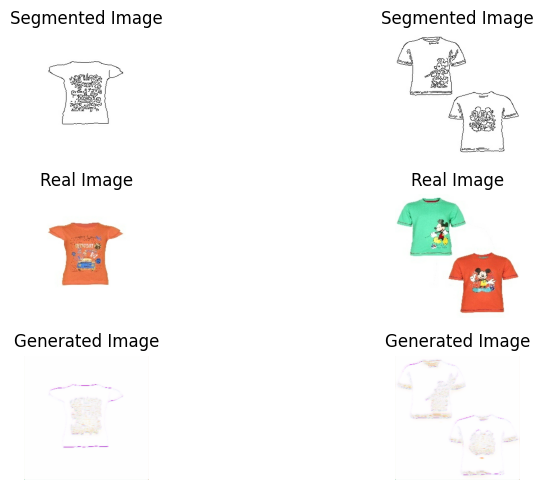

Epoch 2/100, Generator Loss: 3.0273869037628174, Discriminator Loss: 0.62630695104599, Pixel Distance: 0.2029189020395279
Epoch 3/100, Generator Loss: 2.062401294708252, Discriminator Loss: 0.9296987056732178, Pixel Distance: 0.1999235600233078
Epoch 4/100, Generator Loss: 2.658329963684082, Discriminator Loss: 0.7287470102310181, Pixel Distance: 0.19430087506771088
Epoch 5/100, Generator Loss: 7.243494510650635, Discriminator Loss: 0.6805154085159302, Pixel Distance: 0.18792212009429932
Epoch 6/100, Generator Loss: 4.1471686363220215, Discriminator Loss: 0.7570483684539795, Pixel Distance: 0.17713789641857147
Epoch 7/100, Generator Loss: 2.032867908477783, Discriminator Loss: 0.7239667177200317, Pixel Distance: 0.16372835636138916
Epoch 8/100, Generator Loss: 4.646457672119141, Discriminator Loss: 0.6235995292663574, Pixel Distance: 0.1870661973953247
Epoch 9/100, Generator Loss: 4.782276153564453, Discriminator Loss: 0.6243315935134888, Pixel Distance: 0.17485308647155762
Epoch 10/10

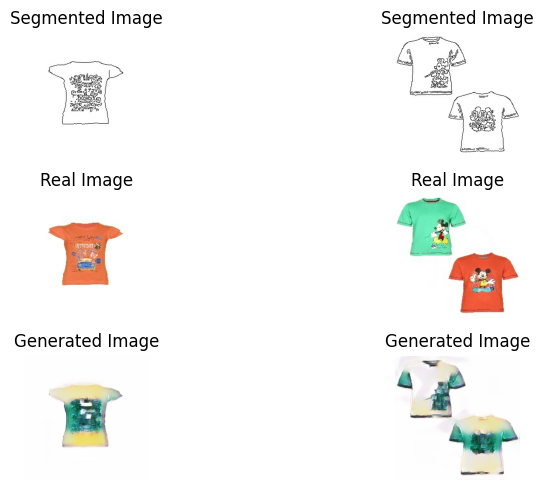

Epoch 12/100, Generator Loss: 6.801811695098877, Discriminator Loss: 1.1286861896514893, Pixel Distance: 0.1731615662574768
Epoch 13/100, Generator Loss: 3.5701470375061035, Discriminator Loss: 1.030238151550293, Pixel Distance: 0.17200453579425812
Epoch 14/100, Generator Loss: 3.94455623626709, Discriminator Loss: 1.3419393301010132, Pixel Distance: 0.18198132514953613
Epoch 15/100, Generator Loss: 3.5925862789154053, Discriminator Loss: 0.8391890525817871, Pixel Distance: 0.1503967046737671
Epoch 16/100, Generator Loss: 5.69782829284668, Discriminator Loss: 1.3684468269348145, Pixel Distance: 0.17190273106098175
Epoch 17/100, Generator Loss: 3.5077686309814453, Discriminator Loss: 0.9645732045173645, Pixel Distance: 0.17787350714206696
Epoch 18/100, Generator Loss: 4.094475746154785, Discriminator Loss: 1.2910511493682861, Pixel Distance: 0.15650327503681183
Epoch 19/100, Generator Loss: 3.4528374671936035, Discriminator Loss: 1.0883371829986572, Pixel Distance: 0.1479424387216568
Ep

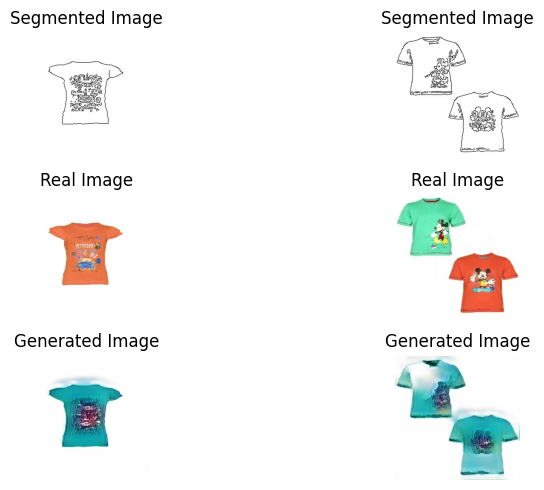

Epoch 22/100, Generator Loss: 4.890225887298584, Discriminator Loss: 1.404259204864502, Pixel Distance: 0.15850917994976044
Epoch 23/100, Generator Loss: 3.411371946334839, Discriminator Loss: 0.7324693202972412, Pixel Distance: 0.176199808716774
Epoch 24/100, Generator Loss: 1.6025817394256592, Discriminator Loss: 0.8387199640274048, Pixel Distance: 0.16711239516735077
Epoch 25/100, Generator Loss: 2.15701961517334, Discriminator Loss: 1.74955415725708, Pixel Distance: 0.16600550711154938
Epoch 26/100, Generator Loss: 6.43540620803833, Discriminator Loss: 0.4648945927619934, Pixel Distance: 0.18969643115997314
Epoch 27/100, Generator Loss: 2.361583709716797, Discriminator Loss: 1.964956521987915, Pixel Distance: 0.15180622041225433
Epoch 28/100, Generator Loss: 4.562213897705078, Discriminator Loss: 0.8738967776298523, Pixel Distance: 0.1859438270330429
Epoch 29/100, Generator Loss: 1.599588394165039, Discriminator Loss: 1.5232923030853271, Pixel Distance: 0.15155647695064545
Epoch 30

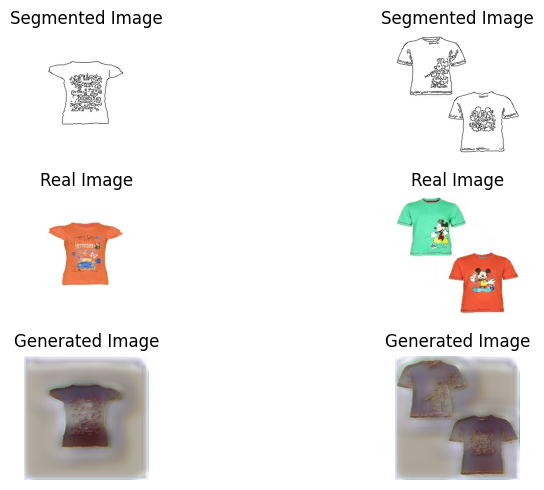

Epoch 32/100, Generator Loss: 3.2956628799438477, Discriminator Loss: 1.0592399835586548, Pixel Distance: 0.15718762576580048
Epoch 33/100, Generator Loss: 3.0131735801696777, Discriminator Loss: 0.5629570484161377, Pixel Distance: 0.18496449291706085
Epoch 34/100, Generator Loss: 1.604461431503296, Discriminator Loss: 1.2317982912063599, Pixel Distance: 0.1566067487001419
Epoch 35/100, Generator Loss: 2.7203445434570312, Discriminator Loss: 0.8999545574188232, Pixel Distance: 0.14411894977092743
Epoch 36/100, Generator Loss: 2.547241687774658, Discriminator Loss: 0.6412988901138306, Pixel Distance: 0.1880633383989334
Epoch 37/100, Generator Loss: 2.730362892150879, Discriminator Loss: 1.4881480932235718, Pixel Distance: 0.16109764575958252
Epoch 38/100, Generator Loss: 2.92360782623291, Discriminator Loss: 0.8261513710021973, Pixel Distance: 0.17114464938640594
Epoch 39/100, Generator Loss: 2.167886734008789, Discriminator Loss: 1.3187415599822998, Pixel Distance: 0.1621343344449997
E

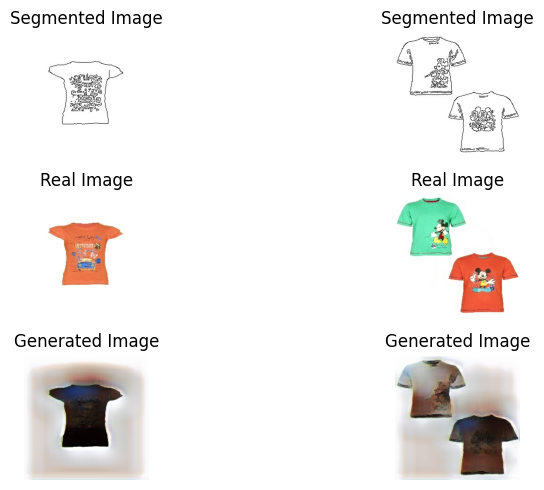

Epoch 42/100, Generator Loss: 4.052639961242676, Discriminator Loss: 1.3664556741714478, Pixel Distance: 0.18490363657474518
Epoch 43/100, Generator Loss: 2.6376585960388184, Discriminator Loss: 0.5827412605285645, Pixel Distance: 0.16373668611049652
Epoch 44/100, Generator Loss: 3.3107166290283203, Discriminator Loss: 0.4680159091949463, Pixel Distance: 0.16034045815467834
Epoch 45/100, Generator Loss: 1.0570839643478394, Discriminator Loss: 1.0035336017608643, Pixel Distance: 0.16281546652317047
Epoch 46/100, Generator Loss: 4.455860614776611, Discriminator Loss: 0.3874376714229584, Pixel Distance: 0.1761535257101059
Epoch 47/100, Generator Loss: 2.7279999256134033, Discriminator Loss: 0.5188669562339783, Pixel Distance: 0.18981440365314484
Epoch 48/100, Generator Loss: 3.2471492290496826, Discriminator Loss: 0.5835441946983337, Pixel Distance: 0.1503528505563736
Epoch 49/100, Generator Loss: 4.097510814666748, Discriminator Loss: 0.46340951323509216, Pixel Distance: 0.16659332811832

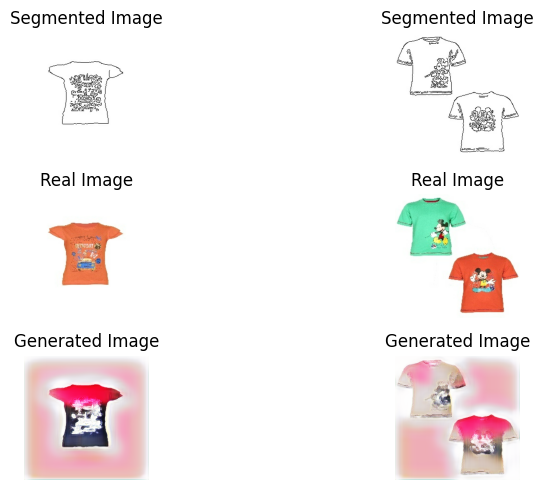

Epoch 52/100, Generator Loss: 2.690308094024658, Discriminator Loss: 0.5266054272651672, Pixel Distance: 0.15872836112976074
Epoch 53/100, Generator Loss: 6.2783002853393555, Discriminator Loss: 0.3450373411178589, Pixel Distance: 0.1686301827430725
Epoch 54/100, Generator Loss: 1.2293466329574585, Discriminator Loss: 0.8361961841583252, Pixel Distance: 0.15376873314380646
Epoch 55/100, Generator Loss: 3.532787799835205, Discriminator Loss: 0.4272617697715759, Pixel Distance: 0.1460568755865097
Epoch 56/100, Generator Loss: 0.9784731268882751, Discriminator Loss: 0.9165417551994324, Pixel Distance: 0.15425270795822144
Epoch 57/100, Generator Loss: 2.6529171466827393, Discriminator Loss: 0.8060858845710754, Pixel Distance: 0.16441960632801056
Epoch 58/100, Generator Loss: 4.890927314758301, Discriminator Loss: 0.32815998792648315, Pixel Distance: 0.1547117978334427
Epoch 59/100, Generator Loss: 1.8969515562057495, Discriminator Loss: 0.7787829041481018, Pixel Distance: 0.149198904633522

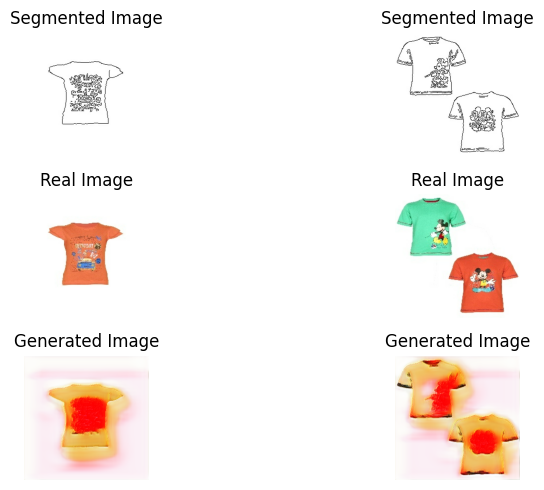

Epoch 62/100, Generator Loss: 13.51317024230957, Discriminator Loss: 0.6570062637329102, Pixel Distance: 0.19266748428344727
Epoch 63/100, Generator Loss: 7.93991756439209, Discriminator Loss: 0.2105359435081482, Pixel Distance: 0.1763749122619629
Epoch 64/100, Generator Loss: 13.157073020935059, Discriminator Loss: 0.46310216188430786, Pixel Distance: 0.19334377348423004
Epoch 65/100, Generator Loss: 5.167596817016602, Discriminator Loss: 0.4697519540786743, Pixel Distance: 0.17656147480010986
Epoch 66/100, Generator Loss: 5.029006004333496, Discriminator Loss: 0.4108319878578186, Pixel Distance: 0.14808446168899536
Epoch 67/100, Generator Loss: 6.100900650024414, Discriminator Loss: 0.3967066705226898, Pixel Distance: 0.1548893004655838
Epoch 68/100, Generator Loss: 3.3266892433166504, Discriminator Loss: 0.8850993514060974, Pixel Distance: 0.1474134773015976
Epoch 69/100, Generator Loss: 1.500166416168213, Discriminator Loss: 0.7510821223258972, Pixel Distance: 0.15730434656143188
E

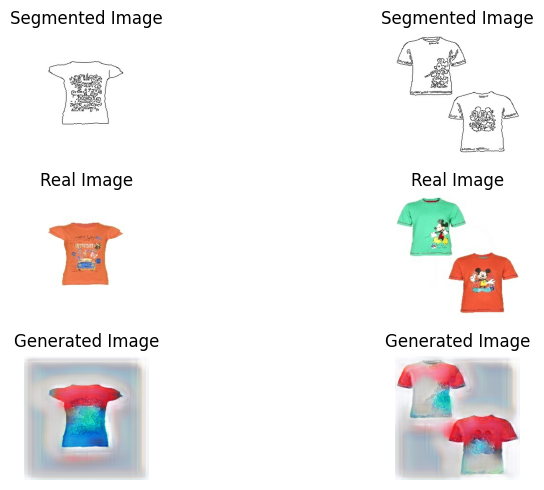

Epoch 72/100, Generator Loss: 8.033299446105957, Discriminator Loss: 0.29753541946411133, Pixel Distance: 0.1448945850133896
Epoch 73/100, Generator Loss: 2.6571733951568604, Discriminator Loss: 0.526080310344696, Pixel Distance: 0.1574493944644928
Epoch 74/100, Generator Loss: 2.2521703243255615, Discriminator Loss: 0.5666336417198181, Pixel Distance: 0.15801909565925598
Epoch 75/100, Generator Loss: 3.4204933643341064, Discriminator Loss: 0.8364360332489014, Pixel Distance: 0.14672939479351044
Epoch 76/100, Generator Loss: 2.150320053100586, Discriminator Loss: 1.5952610969543457, Pixel Distance: 0.13679105043411255
Epoch 77/100, Generator Loss: 10.370433807373047, Discriminator Loss: 0.8328591585159302, Pixel Distance: 0.15096493065357208
Epoch 78/100, Generator Loss: 12.831783294677734, Discriminator Loss: 0.2275223731994629, Pixel Distance: 0.17560362815856934
Epoch 79/100, Generator Loss: 3.431976318359375, Discriminator Loss: 1.7353215217590332, Pixel Distance: 0.161315962672233

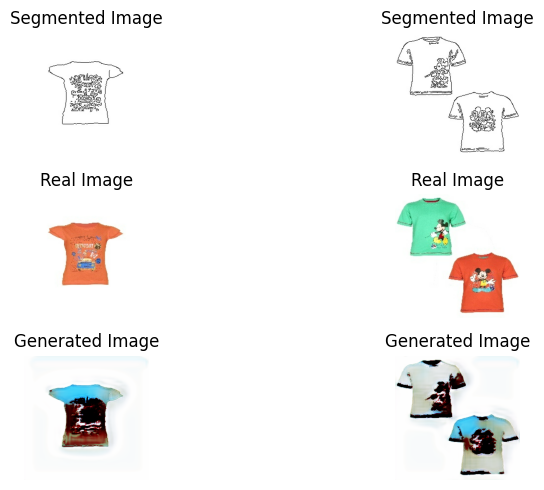

Epoch 82/100, Generator Loss: 2.1273105144500732, Discriminator Loss: 1.7810652256011963, Pixel Distance: 0.16595745086669922
Epoch 83/100, Generator Loss: 1.3190791606903076, Discriminator Loss: 0.7670925259590149, Pixel Distance: 0.1701149195432663
Epoch 84/100, Generator Loss: 3.846663475036621, Discriminator Loss: 0.6214221119880676, Pixel Distance: 0.15018780529499054
Epoch 85/100, Generator Loss: 0.9719966650009155, Discriminator Loss: 1.4654476642608643, Pixel Distance: 0.16427406668663025
Epoch 86/100, Generator Loss: 5.512044906616211, Discriminator Loss: 0.539185643196106, Pixel Distance: 0.1561293601989746
Epoch 87/100, Generator Loss: 1.904219150543213, Discriminator Loss: 0.6496565937995911, Pixel Distance: 0.1533551663160324
Epoch 88/100, Generator Loss: 3.343336582183838, Discriminator Loss: 0.4952445924282074, Pixel Distance: 0.15521733462810516
Epoch 89/100, Generator Loss: 7.360742568969727, Discriminator Loss: 0.22837968170642853, Pixel Distance: 0.16708916425704956


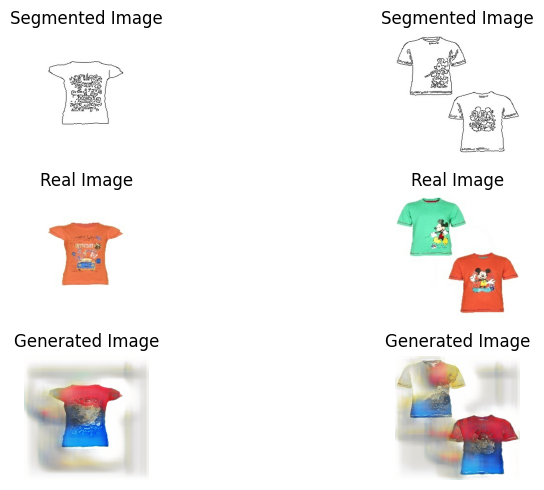

Epoch 92/100, Generator Loss: 16.45153045654297, Discriminator Loss: 1.0266774892807007, Pixel Distance: 0.1676509827375412
Epoch 93/100, Generator Loss: 4.203128814697266, Discriminator Loss: 0.4745146930217743, Pixel Distance: 0.16234852373600006
Epoch 94/100, Generator Loss: 6.662421226501465, Discriminator Loss: 0.34101152420043945, Pixel Distance: 0.13636453449726105
Epoch 95/100, Generator Loss: 2.926974296569824, Discriminator Loss: 0.6098716855049133, Pixel Distance: 0.17981213331222534
Epoch 96/100, Generator Loss: 5.145883560180664, Discriminator Loss: 0.27252307534217834, Pixel Distance: 0.17537711560726166
Epoch 97/100, Generator Loss: 2.977032423019409, Discriminator Loss: 0.8424105644226074, Pixel Distance: 0.14904294908046722
Epoch 98/100, Generator Loss: 0.856173038482666, Discriminator Loss: 1.481235384941101, Pixel Distance: 0.14421133697032928
Epoch 99/100, Generator Loss: 2.697068214416504, Discriminator Loss: 0.8920500874519348, Pixel Distance: 0.15399114787578583


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
epochs = 100
batch_size = 8
train_dataset = create_dataset(paired_paths)
# Train the pix2pix model
train_pix2pix(generator, discriminator, epochs, train_dataset, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)